In [1]:
import numpy as np
import keras
import mne
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import keras
from keras.layers import *
from keras.models import Sequential, Model
from keras.optimizers import *
from keras.losses import *
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, History
import tensorflow as tf
from tensorflow.keras.utils import plot_model 
import keras.backend as K

import matplotlib.pyplot as plt


import os

In [2]:
import utils

In [3]:
print(tf.__version__)

2.3.1


In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
os.getcwd()

'C:\\code\\icn\\ECOG_vs_STN\\EEGNet\\Model_notebooks'

In [6]:
os.listdir('D:\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg')

['sub-000_coordsystem.json',
 'sub-000_electrodes.tsv',
 'sub-000_ses-right_task-force_run-0_channels.tsv',
 'sub-000_ses-right_task-force_run-0_channels_M1.tsv',
 'sub-000_ses-right_task-force_run-0_ieeg.eeg',
 'sub-000_ses-right_task-force_run-0_ieeg.json',
 'sub-000_ses-right_task-force_run-0_ieeg.vhdr',
 'sub-000_ses-right_task-force_run-0_ieeg.vmrk',
 'sub-000_ses-right_task-force_run-1_channels.tsv',
 'sub-000_ses-right_task-force_run-1_channels_M1.tsv',
 'sub-000_ses-right_task-force_run-1_ieeg.eeg',
 'sub-000_ses-right_task-force_run-1_ieeg.json',
 'sub-000_ses-right_task-force_run-1_ieeg.vhdr',
 'sub-000_ses-right_task-force_run-1_ieeg.vmrk',
 'sub-000_ses-right_task-force_run-2_channels.tsv',
 'sub-000_ses-right_task-force_run-2_channels_M1.tsv',
 'sub-000_ses-right_task-force_run-2_ieeg.eeg',
 'sub-000_ses-right_task-force_run-2_ieeg.json',
 'sub-000_ses-right_task-force_run-2_ieeg.vhdr',
 'sub-000_ses-right_task-force_run-2_ieeg.vmrk',
 'sub-000_ses-right_task-force_run-3_c

In [7]:
dirName = 'D:\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg'
fileName = 'sub-000_ses-right_task-force_run-0_ieeg.vhdr'

In [8]:
fname = os.path.join(dirName,fileName)

In [9]:
raw = mne.io.read_raw_brainvision(fname)
data = raw.get_data()
print(data.shape)
X = data[0:6,:]
y = data[-2:,:]

print(X.shape)
print(y.shape)

Extracting parameters from D:\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
(10, 130001)
(6, 130001)
(2, 130001)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X.T, y.T, test_size = 0.2, shuffle = False )

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle = False )

print(X_train.shape)

(104000, 6)


In [31]:
def generator_regression(features, labels, batch_size, epoch_size, rebalance=False, rebalanced_thr=0): 
    
    """
    
    Given the "features" array, this function  returns "batch_size" epochs of size "epoch_size" balanced or unbalanced.
    Batches can be equally sampled by two distributions defined by "rebalanced_thr" if "rebalance" is True. 
    In the rebalance=True case returned batches are shuffled. Corresponding "labels" are returned in the same manner.
    
    params: 
    features (np array) : data array in shape (time, num_channels), 
    labels (np array) : in shape (time),
    batch_size (int) : number of samples per epoch, equivallent to keras model.fit batch_size, 
    epoch_size (int) : time dimension of data vector defined as one training sample
                       dependent on the sampling frequency!,
    rebalance (boolean) : if True data is sampled evenly from the greater and smaller rebalanced_thr distributions, 
    rebalanced_thr (float) : defines rebalancing thresholds for two distributions 
    
    returns:
    batch_features (np array) : batch array in shape (batch_size, 1, num_channels, epoch_size), 
    batch_labels (np array) : label array of size batch_size
    
    The batch_features shape is necessary for tensorflow train
    """
    chans = features.shape[1]
    batch_features = np.zeros([batch_size, 1, chans, epoch_size])  # definition of returned arrays
    batch_labels = np.zeros([batch_size]) 
    
    # the True statement is neccessary due to the "endless" model.fit iterations
    # it is hence terminated by the number of epoch being specified 
    
    while True:
        for idx_label in np.arange(epoch_size, features.shape[0]-batch_size, batch_size): 
            for i in range(batch_size):

                for ch in range(chans):
                    batch_features[i,0,ch,:] = features[(idx_label+i-epoch_size):i+idx_label,ch]
                batch_labels[i] = labels[idx_label+i]
                
            if rebalance == True:    
                
                # resample balancing: 
                # the indices of respective above and below threshold values are concatenated "num_pos" times
                # respectively the distribution with less samples is repeated 
                # thus random sampling is avoided, but data samples are only concatenated 
                
                dat_ = (batch_features, batch_labels)
                ind_below = np.where(batch_labels<=rebalanced_thr)[0]
                ind_above = np.where(batch_labels>rebalanced_thr)[0]
                
                # unformly sample from both distributions
                print(ind_above.shape[0])
                ind_sample_below = np.random.randint(0, ind_below.shape[0], size=int(batch_size/2))
                ind_sample_above = np.random.randint(0, ind_above.shape[0], size=int(batch_size/2))                
                
                batch_features_ = np.concatenate((batch_features[ind_below[ind_sample_below],:,:,:], \
                                batch_features[ind_above[ind_sample_above],:,:,:]), axis=0)
                batch_labels_ = np.concatenate((batch_labels[ind_below[ind_sample_below]], \
                                batch_labels[ind_above[ind_sample_above]]), axis=0)
                yield batch_features_, batch_labels_, [None]
            else:
                yield batch_features, batch_labels, [None]



In [28]:
y_train.shape

(104000, 2)

In [19]:
batch_size = 128
REBALANCE_THR = 0.5
epoch_size = 500

In [32]:
gen_tr = generator_regression(X_train, y_train[:,0], batch_size, \
                    epoch_size, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_test = utils.generator_regression(X_test, y_test, batch_size, \
                    epoch_size, rebalance=True, rebalanced_thr=REBALANCE_THR)

In [33]:
next(gen_tr)

0


ValueError: low >= high

In [13]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [14]:
def r2_keras_loss(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (( 1 - (SS_res/SS_tot) )*-1)+1

In [15]:
def make_cnnModel(input_shape = (500,6,1), summary = True
                 ,n_conv = 3 ,conv_units = [64,64,64] 
                 ,kernel_sizes = [3,3,3] ,conv_activation = ReLU, conv = Conv2D
                 ,pool_func = MaxPool2D ,pool = [0,1,1]
                 ,n_dense = 2, dense_units = [64,120], dense_activation = ReLU
                 ,output_layer = Dense, output_units = 2, output_activation = None
                                                     ):
    
    model = Sequential()
    model.add(Input(input_shape))
#     model.add(Permute((2,1,3) ))

    for i in range(n_conv):
        model.add(conv(conv_units[i], kernel_sizes[i], padding= 'same'))
        model.add(conv_activation())
        if pool[i] == 1:
            model.add(pool_func(pool_size = (2), strides = (2), padding = 'same'))
            
    model.add(Flatten())        
    
    
    for i in range(n_dense):
        model.add(Dense(dense_units[i]))
        model.add(dense_activation())
        
              
    model.add(output_layer(output_units, activation = 'sigmoid') )
    
    
    if summary:
        model.summary()
        
    return model

In [16]:
X_train_ep.shape

(103000, 1000, 6)

In [17]:
cnn_right = make_cnnModel(input_shape= (1000,6,1), pool = [0,1,1], kernel_sizes=[5,5,5], output_units=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1000, 6, 64)       1664      
_________________________________________________________________
re_lu (ReLU)                 (None, 1000, 6, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1000, 6, 64)       102464    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 1000, 6, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 500, 3, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 500, 3, 64)        102464    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 500, 3, 64)        0

In [19]:
cnn_right.compile(optimizer= Adam(), loss= 'mse', metrics= ['mae',r2_keras])

cnn_callbacks = [
    ModelCheckpoint('models/v2/best_cnnR_model.h5', monitor='val_loss', verbose=1, save_best_only= True),
    ReduceLROnPlateau(patience= 2, monitor = 'val_loss'),
    History()
    
]

history_cnn = cnn_right.fit(X_train_ep[:,:,:, np.newaxis],y_train_ep[:,0],batch_size= 128, epochs= 5,
                  callbacks= cnn_callbacks,
                 validation_data= (X_test_ep[:,:,:,np.newaxis], y_test_ep[:,0])
         )

winsound.Beep(freq, duration)

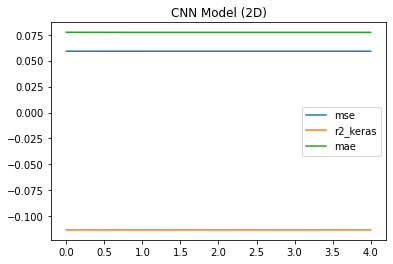

In [23]:
plt.plot(history_cnn.history['loss'], label = 'mse')
plt.plot(history_cnn.history['r2_keras'], label = 'r2_keras')
plt.plot(history_cnn.history['mae'], label = 'mae')
plt.title('CNN Model (2D)')
plt.legend()

In [123]:
cnn_right.evaluate(X_test[:,np.newaxis,:, np.newaxis], y_test[:,0])

813/813 [==============================] - 1s 1ms/step - loss: 0.0705 - mae: 0.0941 - r2_keras: -3307153.5000


[0.07049892842769623, 0.09413135051727295, -3307153.5]

In [24]:
pred = cnn_right.predict(X_test_ep[:,:,:, np.newaxis], verbose= 1)

782/782 [==============================] - 267s 341ms/step


In [27]:
print(y_test_ep.shape)
print(pred.shape)

(25001, 1000, 2)
(25001, 1)


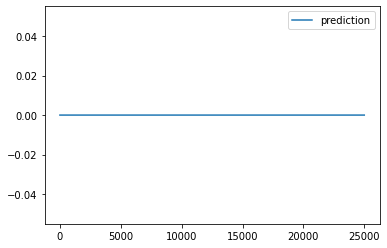

In [25]:
# pred = cnn_right.predict(X_val_ep[:,:,:, np.newaxis])
plt.plot(pred, label = 'prediction')
#plt.plot(y_test_ep[:,0,0], label = 'ground truth', alpha = 0.5)
plt.legend()

## CNN with 500 sample window


In [17]:
window_ms = 0.5
window = int(window_ms* raw.info['sfreq'])
train_gen = Generator(X_train, y_train, window, 1)
test_gen = Generator(X_test, y_test, window, 1)


X_train_ep = np.array(next(train_gen.generator())[0])
y_train_ep = np.array(next(train_gen.generator())[1])
X_test_ep = np.array(next(test_gen.generator())[0])
y_test_ep = np.array(next(test_gen.generator())[1])

print(X_train_ep.shape)
print(y_train_ep.shape)

print(X_test_ep.shape)
print(y_test_ep.shape)

(103500, 500, 6)
(103500, 500, 2)
(25501, 500, 6)
(25501, 500, 2)


In [30]:
cnn_500 = make_cnnModel(input_shape= (500,6,1), pool = [0,1,1], kernel_sizes=[[3,1],[3,1],[3,1]], output_units=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 500, 6, 64)        256       
_________________________________________________________________
re_lu_10 (ReLU)              (None, 500, 6, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 500, 6, 64)        12352     
_________________________________________________________________
re_lu_11 (ReLU)              (None, 500, 6, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 250, 3, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 250, 3, 64)        12352     
_________________________________________________________________
re_lu_12 (ReLU)              (None, 250, 3, 64)       

In [33]:
cnn_500.compile(optimizer= Adam(), loss= 'mse', metrics= ['mae',r2_keras])

cnn_500_callbacks = [
    ModelCheckpoint('models/v2/best_cnn500_model.h5', monitor='val_loss', verbose=1, save_best_only= True),
    ReduceLROnPlateau(patience= 1, monitor = 'val_loss', verbose = 1),
    History()
    
]

history_cnn = cnn_500.fit(X_train_ep[:,:,:, np.newaxis],y_train_ep[:,0],batch_size= 256, epochs= 5,
                  callbacks= cnn_500_callbacks,
                 validation_data= (X_test_ep[:,:,:,np.newaxis], y_test_ep[:,0])
         )

Epoch 1/5
405/405 [==============================] - ETA: 0s - loss: 0.0592 - mae: 0.0776 - r2_keras: -0.1133
Epoch 00001: val_loss improved from inf to 0.06351, saving model to models/v2\best_cnn500_model.h5
405/405 [==============================] - 618s 2s/step - loss: 0.0592 - mae: 0.0776 - r2_keras: -0.1133 - val_loss: 0.0635 - val_mae: 0.0779 - val_r2_keras: 0.5638
Epoch 2/5
405/405 [==============================] - ETA: 0s - loss: 0.0592 - mae: 0.0776 - r2_keras: -0.1133
Epoch 00002: val_loss did not improve from 0.06351

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
405/405 [==============================] - 608s 2s/step - loss: 0.0592 - mae: 0.0776 - r2_keras: -0.1133 - val_loss: 0.0635 - val_mae: 0.0779 - val_r2_keras: 0.5638
Epoch 3/5
405/405 [==============================] - ETA: 0s - loss: 0.0592 - mae: 0.0776 - r2_keras: -0.1133
Epoch 00003: val_loss did not improve from 0.06351

Epoch 00003: ReduceLROnPlateau reducing learning rate to

797/797 [==============================] - 47s 59ms/step


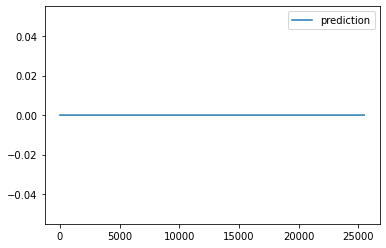

In [34]:
pred = cnn_500.predict(X_test_ep[:,:,:, np.newaxis], verbose= 1)
# pred = cnn_right.predict(X_val_ep[:,:,:, np.newaxis])
plt.plot(pred, label = 'prediction')
#plt.plot(y_test_ep[:,0,0], label = 'ground truth', alpha = 0.5)
plt.legend()

CNN 500 with 25 sized kernels

In [18]:
cnn_500_k25 = make_cnnModel(input_shape= (500,6,1), pool = [0,1,1], kernel_sizes=[[25,1],[25,1],[25,1]], output_units=1 )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 500, 6, 64)        1664      
_________________________________________________________________
re_lu (ReLU)                 (None, 500, 6, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 500, 6, 64)        102464    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 500, 6, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 250, 3, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 3, 64)        102464    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 250, 3, 64)        0

In [19]:
cnn_500_k25.compile(optimizer= Adam(), loss= 'mse', metrics= ['mae',r2_keras])

cnn_500k25_callbacks = [
    ModelCheckpoint('models/v2/best_cnn500k25_model.h5', monitor='val_loss', verbose=1, save_best_only= True),
    ReduceLROnPlateau(patience= 1, monitor = 'val_loss', verbose = 1),
    History()
    
]

history_cnn_500k25 = cnn_500_k25.fit(X_train_ep[:,:,:, np.newaxis],y_train_ep[:,0],batch_size= 128, epochs= 5,
                  callbacks= cnn_500k25_callbacks,
                 validation_data= (X_test_ep[:,:,:,np.newaxis], y_test_ep[:,0])
         )

Epoch 1/5
809/809 [==============================] - ETA: 0s - loss: 0.0592 - mae: 0.0776 - r2_keras: -0.1138
Epoch 00001: val_loss improved from inf to 0.06351, saving model to models/v2\best_cnn500k25_model.h5
809/809 [==============================] - 2854s 4s/step - loss: 0.0592 - mae: 0.0776 - r2_keras: -0.1138 - val_loss: 0.0635 - val_mae: 0.0779 - val_r2_keras: 0.5804
Epoch 2/5
809/809 [==============================] - ETA: 0s - loss: 0.0592 - mae: 0.0776 - r2_keras: -0.1137
Epoch 00002: val_loss did not improve from 0.06351

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
809/809 [==============================] - 2685s 3s/step - loss: 0.0592 - mae: 0.0776 - r2_keras: -0.1137 - val_loss: 0.0635 - val_mae: 0.0779 - val_r2_keras: 0.5804
Epoch 3/5
809/809 [==============================] - ETA: 0s - loss: 0.0592 - mae: 0.0776 - r2_keras: -0.1138
Epoch 00003: val_loss did not improve from 0.06351

Epoch 00003: ReduceLROnPlateau reducing learning ra

797/797 [==============================] - 143s 179ms/step


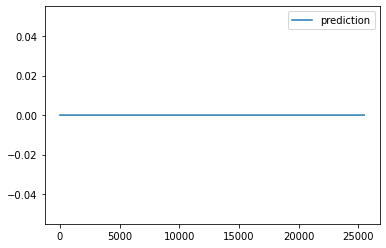

In [20]:
pred = cnn_500_k25.predict(X_test_ep[:,:,:, np.newaxis], verbose= 1)
# pred = cnn_right.predict(X_val_ep[:,:,:, np.newaxis])
plt.plot(pred, label = 'prediction')
#plt.plot(y_test_ep[:,0,0], label = 'ground truth', alpha = 0.5)
plt.legend()

cnn 500_k3

In [24]:
cnn_500_k3 = make_cnnModel(input_shape= (500,6,1), n_conv= 6
                           , pool = [0,1,1,1,1,1], kernel_sizes=[3,3,3,3,3,3]
                           , conv_units = [6,6,6,6,6,6] ,  output_units=1  )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 500, 6, 6)         60        
_________________________________________________________________
re_lu_10 (ReLU)              (None, 500, 6, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 500, 6, 6)         330       
_________________________________________________________________
re_lu_11 (ReLU)              (None, 500, 6, 6)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 250, 3, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 250, 3, 6)         330       
_________________________________________________________________
re_lu_12 (ReLU)              (None, 250, 3, 6)        

In [25]:
cnn_500_k3.compile(optimizer= Adam(), loss= 'mse', metrics= ['mae',r2_keras])

cnn_500k3_callbacks = [
    ModelCheckpoint('models/v2/best_cnn500k3_model.h5', monitor='val_loss', verbose=1, save_best_only= True),
    ReduceLROnPlateau(patience= 1, monitor = 'val_loss', verbose = 1),
    History()
    
]

history_cnn_500k3 = cnn_500_k3.fit(X_train_ep[:,:,:, np.newaxis],y_train_ep[:,0],batch_size= 128, epochs= 2,
                  callbacks= cnn_500k3_callbacks,
                 validation_data= (X_test_ep[:,:,:,np.newaxis], y_test_ep[:,0])
         )

Epoch 1/2
809/809 [==============================] - ETA: 0s - loss: 0.0350 - mae: 0.0880 - r2_keras: 0.3399
Epoch 00001: val_loss improved from inf to 0.07258, saving model to models/v2\best_cnn500k3_model.h5
809/809 [==============================] - 163s 202ms/step - loss: 0.0350 - mae: 0.0880 - r2_keras: 0.3399 - val_loss: 0.0726 - val_mae: 0.1213 - val_r2_keras: -35530380.0000
Epoch 2/2
809/809 [==============================] - ETA: 0s - loss: 0.0274 - mae: 0.0728 - r2_keras: 0.4835
Epoch 00002: val_loss improved from 0.07258 to 0.07074, saving model to models/v2\best_cnn500k3_model.h5
809/809 [==============================] - 164s 203ms/step - loss: 0.0274 - mae: 0.0728 - r2_keras: 0.4835 - val_loss: 0.0707 - val_mae: 0.1161 - val_r2_keras: -31001432.0000


797/797 [==============================] - 21s 27ms/step


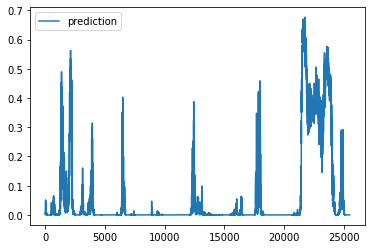

In [27]:
pred = cnn_500_k3.predict(X_test_ep[:,:,:, np.newaxis], verbose= 1)
# pred = cnn_right.predict(X_val_ep[:,:,:, np.newaxis])
plt.plot(pred, label = 'prediction')
#plt.plot(y_test_ep[:,0,0], label = 'ground truth', alpha = 0.5)
plt.legend()

cnn


In [28]:
cnn_500_k100 = make_cnnModel(input_shape= (500,6,1), pool = [0,1,1], summary = False,
                            kernel_sizes=[[100,6],[50,6],[25,6]], output_units=1,
                            conv_units = [ 6, 6, 6], dense_units= [100,100])

cnn_500_k100.compile(optimizer= Adam(), loss= 'mse', metrics= ['mae',r2_keras])

cnn_500_k100_callbacks = [
    ModelCheckpoint('models/v2/best_cnn_500_k100_model.h5', monitor='val_loss', verbose=1, save_best_only= True),
    ReduceLROnPlateau(patience= 1, monitor = 'val_loss', verbose = 1),
    History()
    
]

history_cnn_500_k100 = cnn_500_k100.fit(X_train_ep[:,:,:, np.newaxis],y_train_ep[:,0],batch_size= 128, epochs= 2,
                  callbacks= cnn_500_k100_callbacks,
                 validation_data= (X_test_ep[:,:,:,np.newaxis], y_test_ep[:,0])
         )


Epoch 1/2
809/809 [==============================] - ETA: 0s - loss: 0.0592 - mae: 0.0776 - r2_keras: -0.1140
Epoch 00001: val_loss improved from inf to 0.06351, saving model to models/v2\best_cnn_500_k100_model.h5
809/809 [==============================] - 2331s 3s/step - loss: 0.0592 - mae: 0.0776 - r2_keras: -0.1140 - val_loss: 0.0635 - val_mae: 0.0779 - val_r2_keras: 0.5804
Epoch 2/2
809/809 [==============================] - ETA: 0s - loss: 0.0592 - mae: 0.0776 - r2_keras: -0.1137
Epoch 00002: val_loss did not improve from 0.06351

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
809/809 [==============================] - 2325s 3s/step - loss: 0.0592 - mae: 0.0776 - r2_keras: -0.1137 - val_loss: 0.0635 - val_mae: 0.0779 - val_r2_keras: 0.5804


797/797 [==============================] - 105s 132ms/step


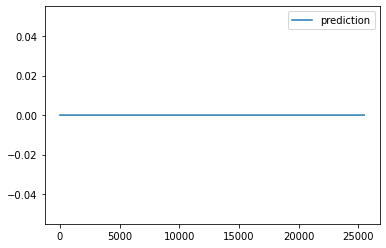

In [29]:
pred = cnn_500_k100.predict(X_test_ep[:,:,:, np.newaxis], verbose= 1)
# pred = cnn_right.predict(X_val_ep[:,:,:, np.newaxis])
plt.plot(pred, label = 'prediction')
#plt.plot(y_test_ep[:,0,0], label = 'ground truth', alpha = 0.5)
plt.legend()

In [30]:
cnn_500_k500 = make_cnnModel(input_shape= (500,6,1), pool = [0,1,1], summary = False,
                            kernel_sizes=[[500,2],[500,2],[500,2]], output_units=1,
                            conv_units = [ 6, 6, 6], dense_units= [100,100])

cnn_500_k500.compile(optimizer= Adam(), loss= 'mse', metrics= ['mae',r2_keras])

cnn_500_k500_callbacks = [
    ModelCheckpoint('models/v2/best_cnn_500_k500_model.h5', monitor='val_loss', verbose=1, save_best_only= True),
    ReduceLROnPlateau(patience= 1, monitor = 'val_loss', verbose = 1),
    History()
    
]

history_cnn_500_k500 = cnn_500_k500.fit(X_train_ep[:,:,:, np.newaxis],y_train_ep[:,0],batch_size= 128, epochs= 2,
                  callbacks= cnn_500_k500_callbacks,
                 validation_data= (X_test_ep[:,:,:,np.newaxis], y_test_ep[:,0])
         )


Epoch 1/2
809/809 [==============================] - ETA: 0s - loss: 0.0594 - mae: 0.0779 - r2_keras: -0.1185
Epoch 00001: val_loss improved from inf to 0.06351, saving model to models/v2\best_cnn_500_k500_model.h5
809/809 [==============================] - 7741s 10s/step - loss: 0.0594 - mae: 0.0779 - r2_keras: -0.1185 - val_loss: 0.0635 - val_mae: 0.0779 - val_r2_keras: 0.5804
Epoch 2/2
809/809 [==============================] - ETA: 0s - loss: 0.0592 - mae: 0.0776 - r2_keras: -0.1136
Epoch 00002: val_loss did not improve from 0.06351

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
809/809 [==============================] - 7773s 10s/step - loss: 0.0592 - mae: 0.0776 - r2_keras: -0.1136 - val_loss: 0.0635 - val_mae: 0.0779 - val_r2_keras: 0.5804


# Autoencoder

In [125]:
rnn_backup = rnn_right
cnn_backup = cnn_right

In [112]:
def make_aeModel(input_shape = (1,6), summary = True
                 ,rnn_model = rnn_backup, cnn_model = cnn_backup,
                 output_n = 2
                                                        ):
    
    input_layer = Input(input_shape)
    input_layer_extended = tf.keras.backend.expand_dims(input_layer)
    
    rnn_model = Model(rnn_model.input, rnn_model.layers[-2].output, name = 'RNN_Model')
    cnn_model = Model(cnn_model.input, cnn_model.layers[-2].output, name = 'CNN_Model')

    for layer in rnn_model.layers:
        layer.trainable = False
    
    for layer in cnn_model.layers:
        layer.trainable = False
    
    rnn_features = rnn_model(input_layer)
    cnn_features = cnn_model(input_layer_extended)
    
    concat = Concatenate(axis = -1, name = 'Concat')([rnn_features,cnn_features])
    
    x = Dense(200, name = 'Dense_1')(concat)
    x = ReLU()(x)
    x = Dense(100, name = 'Dense_2')(x)
    x = ReLU()(x)
    output = Dense(output_n, activation = 'sigmoid' , name = 'output')(x)
    
    ae = Model(input_layer, output)
    
    
    ae.summary()
    
    return ae

In [140]:
ae_right = make_aeModel(output_n= 1)

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 1, 6)]       0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_3 (Tenso [(None, 1, 6, 1)]    0           input_12[0][0]                   
__________________________________________________________________________________________________
RNN_Model (Functional)          (None, 64)           74816       input_12[0][0]                   
__________________________________________________________________________________________________
CNN_Model (Functional)          (None, 120)          90552       tf_op_layer_ExpandDims_3[0][0]   
_______________________________________________________________________________________

In [141]:
ae_right.compile(optimizer=Adam(), loss = r2_keras_loss, metrics=['mae', 'mse', r2_keras])

In [142]:
ae_callbacks = [
    ModelCheckpoint('best_aeR_model.h5', monitor='val_loss', verbose=1, save_best_only= True),
    ReduceLROnPlateau(patience= 10, monitor = 'val_loss'),
    History()
    
]

In [144]:
history_ae = ae_right.fit(X_train[:,np.newaxis,:],y_train,batch_size= 128, epochs= 500,
                  callbacks= ae_callbacks,
                  validation_data= (X_val[:, np.newaxis, :], y_val[:,0])
         )

winsound.Beep(freq, duration)

Epoch 1/500
639/650 [============================>.] - ETA: 0s - loss: 0.6732 - mae: 0.0916 - mse: 0.0348 - r2_keras: 0.3268
Epoch 00001: val_loss did not improve from inf
650/650 [==============================] - 3s 5ms/step - loss: 0.6732 - mae: 0.0916 - mse: 0.0348 - r2_keras: 0.3268 - val_loss: inf - val_mae: 0.1174 - val_mse: 0.0714 - val_r2_keras: -13799993.0000
Epoch 2/500
643/650 [============================>.] - ETA: 0s - loss: 0.6726 - mae: 0.0915 - mse: 0.0348 - r2_keras: 0.3274
Epoch 00002: val_loss did not improve from inf
650/650 [==============================] - 3s 5ms/step - loss: 0.6727 - mae: 0.0915 - mse: 0.0348 - r2_keras: 0.3273 - val_loss: inf - val_mae: 0.1201 - val_mse: 0.0714 - val_r2_keras: -14771726.0000
Epoch 3/500
644/650 [============================>.] - ETA: 0s - loss: 0.6719 - mae: 0.0913 - mse: 0.0347 - r2_keras: 0.3281
Epoch 00003: val_loss did not improve from inf
650/650 [==============================] - 3s 5ms/step - loss: 0.6716 - mae: 0.0914 

KeyboardInterrupt: 

In [102]:
ae_right.evaluate(X_test[:,np.newaxis,:], y_test )

813/813 [==============================] - 2s 2ms/step - loss: 0.0661 - mae: 0.1154 - r2_keras: -5246552.5000


[0.06606696546077728, 0.11539081484079361, -5246552.5]

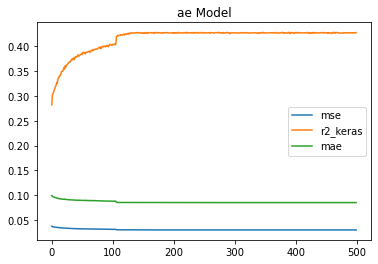

In [103]:
plt.plot(history_ae.history['loss'], label = 'mse')
plt.plot(history_ae.history['r2_keras'], label = 'r2_keras')
plt.plot(history_ae.history['mae'], label = 'mae')
plt.title('ae Model')
plt.legend()

In [106]:
ae_predictions = ae_right.predict(X_test[:,np.newaxis,:], verbose= 1)

813/813 [==============================] - 2s 2ms/step


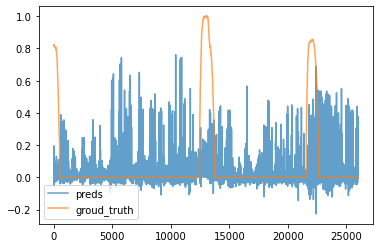

In [109]:
# ae_predictions = ae_predictions.predict(X_test[:,np.newaxis,:], verbose= 1)
plt.plot(ae_predictions[:,0], alpha = 0.7, label = 'preds')
plt.plot(y_test[:,0], alpha = 0.7, label = 'groud_truth')
# plt.ylim(0,7)
plt.legend()

# Deep forward NN


In [499]:
fnn = Sequential()
fnn.add(Conv2D(16, kernel_size = 6, input_shape = (200,6,1), activation = 'selu', padding = 'same'))
fnn.add(Conv2D(16, kernel_size = 6, activation = 'selu', padding = 'same'))
fnn.add(Conv2D(16, kernel_size = 6, activation = 'selu'))
# fnn.add(Dense(50, input_shape = (6,1,), activation = "selu"))
fnn.add(Flatten())
fnn.add(Dense(10, activation = 'selu'))

# fnn.add(LSTM(50, return_sequences =True))
# fnn.add(LSTM(50))

fnn.add(Dense(50, activation = 'selu'))
# fnn.add(Dense(100, activation = 'selu'))
# fnn.add(Dense(50, activation = 'selu'))
# fnn.add(Dense(24, activation = 'selu'))
# fnn.add(Dense(12, activation = 'selu'))
fnn.add(Dense(1, activation = 'sigmoid'))
fnn.summary()

fnn.compile(optimizer = Adam(), loss = "mae", metrics = ['mse',r2_keras])

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 200, 6, 16)        592       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 200, 6, 16)        9232      
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 195, 1, 16)        9232      
_________________________________________________________________
flatten_7 (Flatten)          (None, 3120)              0         
_________________________________________________________________
dense_205 (Dense)            (None, 10)                31210     
_________________________________________________________________
dense_206 (Dense)            (None, 50)                550       
_________________________________________________________________
dense_207 (Dense)            (None, 1)               

In [498]:
# fnn.fit(X_train[:,:,np.newaxis], y_train[:,0], epochs  = 500,
#        validation_data= (X_val[:,:,np.newaxis], y_val[:,0])
#        )

In [533]:
window = 200
gen = ecog_gen(X_train[:,:, np.newaxis], y_train[:,0], window= window, batch_size=128)

In [538]:
fnn.fit( gen, steps_per_epoch= (len(X_train)-window ), epochs= 5 )

Epoch 1/5


TypeError: 'NoneType' object is not callable

# Self Attention 

In [110]:
def self_attention(x, conv= None, k_s = 6, atten_func = Dense, d_k = 6, activation = ReLU):
    
    # input shape should (ch,1), ch is number of ecog channels
    
    if conv != None:
        input_x = conv(d_k, kernel_size = k_s, padding = 'same')(x)
    else:
        input_x = x 
        
        
    query = atten_func(d_k)(input_x)
    query = activation()(query)
    
    key   = atten_func(d_k)(input_x)
    key = activation()(key)
    
    value = atten_func(d_k, activation = 'relu')(input_x)
    value = activation()(value)
    
    matmul = tf.matmul(query, key, transpose_a=True)

    matmul_sqrt = matmul/np.sqrt(query.shape[1])
    softmax = Softmax()(matmul_sqrt)
    matmul_2 = tf.matmul(value, softmax, transpose_b=False)

    d = Dense(d_k)(matmul_2)
    d = activation()(d)

    d2 = Dense(d_k)(d)
    addition = Add()([x, d2])
    norm = BatchNormalization()(addition)
    
    return norm


In [126]:
def make_attenModel(input_shape = (1,6), summary = True
                , n_heads = 3, atten_func = Dense
                , n_outputs = 2
                    
                                                   
                                                   ):
    input_layer = Input(input_shape)
    
    # Encoder
    atten_heads = []
    for i in range(n_heads):
        atten_heads.append(self_attention(input_layer,atten_func= atten_func ))
        
    concat = atten_heads[0]
    for i in range(len(atten_heads)-1):
        concat = Concatenate()([concat,atten_heads[i+1]])
        
    f = Flatten()(concat)
    d = Dense(50)(f)
    d = ReLU()(d)
    d = Dense(50)(d)
    d = ReLU()(d)
    
    output = Dense(n_outputs, 'sigmoid')(d)
    
    
    model = Model(input_layer, output)
    
    if summary:
        model.summary()
    
    return model
    


In [127]:
atten = make_attenModel(n_outputs=1)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 1, 6)]       0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 1, 6)         42          input_10[0][0]                   
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 1, 6)         42          input_10[0][0]                   
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 1, 6)         42          input_10[0][0]                   
_______________________________________________________________________________________

In [128]:
atten.compile(optimizer = Adam(), loss = 'mse', metrics= ['mae', r2_keras])

In [129]:
atten_callbacks = [
    ModelCheckpoint('best_atten_model.h5', monitor='loss', verbose=1, save_best_only= True),
    ReduceLROnPlateau(patience= 10, monitor = 'loss'),
    History()
    
]

In [131]:
history_atten = atten.fit(X_train[:,np.newaxis,:],y_train,batch_size= 128, epochs= 500,
                  callbacks= atten_callbacks,
                  validation_data= (X_val[:, np.newaxis, :], y_val)
         )

winsound.Beep(freq, duration)

Epoch 1/500
631/650 [============================>.] - ETA: 0s - loss: 0.0345 - mae: 0.0948 - r2_keras: 0.3327
Epoch 00001: loss improved from 0.03452 to 0.03440, saving model to best_atten_model.h5
650/650 [==============================] - 2s 4ms/step - loss: 0.0344 - mae: 0.0947 - r2_keras: 0.3337 - val_loss: 0.0708 - val_mae: 0.1307 - val_r2_keras: -17600684.0000
Epoch 2/500
643/650 [============================>.] - ETA: 0s - loss: 0.0340 - mae: 0.0937 - r2_keras: 0.3410
Epoch 00002: loss improved from 0.03440 to 0.03401, saving model to best_atten_model.h5
650/650 [==============================] - 2s 3ms/step - loss: 0.0340 - mae: 0.0937 - r2_keras: 0.3405 - val_loss: 0.0708 - val_mae: 0.1318 - val_r2_keras: -18832324.0000
Epoch 3/500
639/650 [============================>.] - ETA: 0s - loss: 0.0339 - mae: 0.0933 - r2_keras: 0.3425
Epoch 00003: loss improved from 0.03401 to 0.03390, saving model to best_atten_model.h5
650/650 [==============================] - 2s 3ms/step - loss

Epoch 24/500
627/650 [===========================>..] - ETA: 0s - loss: 0.0325 - mae: 0.0889 - r2_keras: 0.3711
Epoch 00024: loss did not improve from 0.03241
650/650 [==============================] - 2s 3ms/step - loss: 0.0325 - mae: 0.0889 - r2_keras: 0.3709 - val_loss: 0.0714 - val_mae: 0.1246 - val_r2_keras: -15894467.0000
Epoch 25/500
646/650 [============================>.] - ETA: 0s - loss: 0.0324 - mae: 0.0888 - r2_keras: 0.3726
Epoch 00025: loss improved from 0.03241 to 0.03237, saving model to best_atten_model.h5
650/650 [==============================] - 2s 3ms/step - loss: 0.0324 - mae: 0.0887 - r2_keras: 0.3728 - val_loss: 0.0717 - val_mae: 0.1276 - val_r2_keras: -19158272.0000
Epoch 26/500
644/650 [============================>.] - ETA: 0s - loss: 0.0323 - mae: 0.0886 - r2_keras: 0.3739
Epoch 00026: loss improved from 0.03237 to 0.03232, saving model to best_atten_model.h5
650/650 [==============================] - 2s 3ms/step - loss: 0.0323 - mae: 0.0886 - r2_keras: 0.3

Epoch 48/500
628/650 [===========================>..] - ETA: 0s - loss: 0.0318 - mae: 0.0879 - r2_keras: 0.3844
Epoch 00048: loss improved from 0.03190 to 0.03180, saving model to best_atten_model.h5
650/650 [==============================] - 2s 3ms/step - loss: 0.0318 - mae: 0.0879 - r2_keras: 0.3838 - val_loss: 0.0718 - val_mae: 0.1276 - val_r2_keras: -19420602.0000
Epoch 49/500
643/650 [============================>.] - ETA: 0s - loss: 0.0319 - mae: 0.0880 - r2_keras: 0.3817
Epoch 00049: loss did not improve from 0.03180
650/650 [==============================] - 2s 3ms/step - loss: 0.0319 - mae: 0.0881 - r2_keras: 0.3815 - val_loss: 0.0722 - val_mae: 0.1298 - val_r2_keras: -20433634.0000
Epoch 50/500
649/650 [============================>.] - ETA: 0s - loss: 0.0317 - mae: 0.0876 - r2_keras: 0.3866
Epoch 00050: loss improved from 0.03180 to 0.03169, saving model to best_atten_model.h5
650/650 [==============================] - 2s 3ms/step - loss: 0.0317 - mae: 0.0877 - r2_keras: 0.3

KeyboardInterrupt: 

In [132]:
atten.evaluate(X_test[:,np.newaxis,:], y_test)

163/163 [==============================] - 0s 1ms/step - loss: 0.0728 - mae: 0.1285 - r2_keras: -21757084.0000


[0.0727914348244667, 0.1284676343202591, -21757084.0]

In [429]:
atten_2 = make_attenModel(n_heads=12)
atten_2.compile(optimizer = SGD(), loss = 'mse', metrics= ['mae', r2_keras])
atten_2_callbacks = [
    ModelCheckpoint('best_atten2_model.h5', monitor='loss', verbose=1, save_best_only= True),
    ReduceLROnPlateau(patience= 10, monitor = 'loss'),
    History()
    
]



Model: "functional_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_152 (InputLayer)          [(None, 1, 6)]       0                                            
__________________________________________________________________________________________________
dense_781 (Dense)               (None, 1, 6)         42          input_152[0][0]                  
__________________________________________________________________________________________________
dense_782 (Dense)               (None, 1, 6)         42          input_152[0][0]                  
__________________________________________________________________________________________________
dense_786 (Dense)               (None, 1, 6)         42          input_152[0][0]                  
______________________________________________________________________________________

In [430]:
history_atten2 = atten_2.fit(X_train[:,np.newaxis,:],y_train,batch_size= 128, epochs= 500,
                  callbacks= atten_2_callbacks,
#                   validation_data= (X_val[:, np.newaxis, :], y_val)
         )

winsound.Beep(freq, duration)

Epoch 1/500
809/813 [============================>.] - ETA: 0s - loss: 2.1303 - mae: 0.8744 - r2_keras: 0.1097
Epoch 00001: loss improved from inf to 2.13077, saving model to best_atten2_model.h5
813/813 [==============================] - 4s 5ms/step - loss: 2.1308 - mae: 0.8746 - r2_keras: 0.1099
Epoch 2/500
804/813 [============================>.] - ETA: 0s - loss: 1.9145 - mae: 0.8422 - r2_keras: 0.1984
Epoch 00002: loss improved from 2.13077 to 1.91385, saving model to best_atten2_model.h5
813/813 [==============================] - 4s 5ms/step - loss: 1.9139 - mae: 0.8421 - r2_keras: 0.1987
Epoch 3/500
807/813 [============================>.] - ETA: 0s - loss: 1.7866 - mae: 0.8188 - r2_keras: 0.2506
Epoch 00003: loss improved from 1.91385 to 1.78572, saving model to best_atten2_model.h5
813/813 [==============================] - 5s 6ms/step - loss: 1.7857 - mae: 0.8186 - r2_keras: 0.2507
Epoch 4/500
812/813 [============================>.] - ETA: 0s - loss: 1.6999 - mae: 0.8042 - r

Epoch 28/500
811/813 [============================>.] - ETA: 0s - loss: 1.1634 - mae: 0.6206 - r2_keras: 0.5087
Epoch 00028: loss improved from 1.17727 to 1.16359, saving model to best_atten2_model.h5
813/813 [==============================] - 6s 7ms/step - loss: 1.1636 - mae: 0.6207 - r2_keras: 0.5087
Epoch 29/500
813/813 [==============================] - ETA: 0s - loss: 1.1578 - mae: 0.6169 - r2_keras: 0.5106
Epoch 00029: loss improved from 1.16359 to 1.15776, saving model to best_atten2_model.h5
813/813 [==============================] - 6s 7ms/step - loss: 1.1578 - mae: 0.6169 - r2_keras: 0.5106
Epoch 30/500
807/813 [============================>.] - ETA: 0s - loss: 1.1489 - mae: 0.6136 - r2_keras: 0.5138
Epoch 00030: loss improved from 1.15776 to 1.14949, saving model to best_atten2_model.h5
813/813 [==============================] - 6s 7ms/step - loss: 1.1495 - mae: 0.6137 - r2_keras: 0.5142
Epoch 31/500
805/813 [============================>.] - ETA: 0s - loss: 1.1395 - mae: 0.

Epoch 56/500
809/813 [============================>.] - ETA: 0s - loss: 1.0483 - mae: 0.5727 - r2_keras: 0.5565
Epoch 00056: loss did not improve from 1.03685
813/813 [==============================] - 5s 7ms/step - loss: 1.0485 - mae: 0.5727 - r2_keras: 0.5564
Epoch 57/500
806/813 [============================>.] - ETA: 0s - loss: 1.0346 - mae: 0.5665 - r2_keras: 0.5622
Epoch 00057: loss improved from 1.03685 to 1.03455, saving model to best_atten2_model.h5
813/813 [==============================] - 6s 7ms/step - loss: 1.0345 - mae: 0.5665 - r2_keras: 0.5624
Epoch 58/500
811/813 [============================>.] - ETA: 0s - loss: 1.0291 - mae: 0.5648 - r2_keras: 0.5662
Epoch 00058: loss improved from 1.03455 to 1.02918, saving model to best_atten2_model.h5
813/813 [==============================] - 6s 7ms/step - loss: 1.0292 - mae: 0.5649 - r2_keras: 0.5661
Epoch 59/500
805/813 [============================>.] - ETA: 0s - loss: 1.0327 - mae: 0.5667 - r2_keras: 0.5650
Epoch 00059: loss 

Epoch 85/500
809/813 [============================>.] - ETA: 0s - loss: 0.9686 - mae: 0.5392 - r2_keras: 0.5907
Epoch 00085: loss improved from 0.96970 to 0.96839, saving model to best_atten2_model.h5
813/813 [==============================] - 6s 7ms/step - loss: 0.9684 - mae: 0.5392 - r2_keras: 0.5907
Epoch 86/500
807/813 [============================>.] - ETA: 0s - loss: 0.9677 - mae: 0.5397 - r2_keras: 0.5916
Epoch 00086: loss improved from 0.96839 to 0.96728, saving model to best_atten2_model.h5
813/813 [==============================] - 6s 7ms/step - loss: 0.9673 - mae: 0.5397 - r2_keras: 0.5917
Epoch 87/500
813/813 [==============================] - ETA: 0s - loss: 0.9658 - mae: 0.5392 - r2_keras: 0.5914
Epoch 00087: loss improved from 0.96728 to 0.96577, saving model to best_atten2_model.h5
813/813 [==============================] - 6s 7ms/step - loss: 0.9658 - mae: 0.5392 - r2_keras: 0.5914
Epoch 88/500
810/813 [============================>.] - ETA: 0s - loss: 0.9636 - mae: 0.

Epoch 114/500
812/813 [============================>.] - ETA: 0s - loss: 0.9281 - mae: 0.5207 - r2_keras: 0.6069
Epoch 00114: loss did not improve from 0.91886
813/813 [==============================] - 5s 7ms/step - loss: 0.9280 - mae: 0.5207 - r2_keras: 0.6071
Epoch 115/500
809/813 [============================>.] - ETA: 0s - loss: 0.9288 - mae: 0.5209 - r2_keras: 0.6069
Epoch 00115: loss did not improve from 0.91886
813/813 [==============================] - 5s 7ms/step - loss: 0.9284 - mae: 0.5209 - r2_keras: 0.6070
Epoch 116/500
811/813 [============================>.] - ETA: 0s - loss: 0.9247 - mae: 0.5195 - r2_keras: 0.6088
Epoch 00116: loss did not improve from 0.91886
813/813 [==============================] - 5s 7ms/step - loss: 0.9243 - mae: 0.5194 - r2_keras: 0.6087
Epoch 117/500
807/813 [============================>.] - ETA: 0s - loss: 0.9251 - mae: 0.5190 - r2_keras: 0.6085
Epoch 00117: loss did not improve from 0.91886
813/813 [==============================] - 5s 7ms/s

811/813 [============================>.] - ETA: 0s - loss: 0.8970 - mae: 0.5048 - r2_keras: 0.6204
Epoch 00144: loss did not improve from 0.89410
813/813 [==============================] - 6s 7ms/step - loss: 0.8971 - mae: 0.5048 - r2_keras: 0.6202
Epoch 145/500
810/813 [============================>.] - ETA: 0s - loss: 0.8903 - mae: 0.5028 - r2_keras: 0.6223
Epoch 00145: loss improved from 0.89410 to 0.89004, saving model to best_atten2_model.h5
813/813 [==============================] - 6s 7ms/step - loss: 0.8900 - mae: 0.5027 - r2_keras: 0.6223
Epoch 146/500
809/813 [============================>.] - ETA: 0s - loss: 0.8978 - mae: 0.5036 - r2_keras: 0.6212
Epoch 00146: loss did not improve from 0.89004
813/813 [==============================] - 6s 7ms/step - loss: 0.8975 - mae: 0.5036 - r2_keras: 0.6213
Epoch 147/500
809/813 [============================>.] - ETA: 0s - loss: 0.8959 - mae: 0.5035 - r2_keras: 0.6216
Epoch 00147: loss did not improve from 0.89004
813/813 [==============

Epoch 203/500
812/813 [============================>.] - ETA: 0s - loss: 0.8534 - mae: 0.4817 - r2_keras: 0.6387
Epoch 00203: loss improved from 0.85397 to 0.85345, saving model to best_atten2_model.h5
813/813 [==============================] - 6s 7ms/step - loss: 0.8534 - mae: 0.4818 - r2_keras: 0.6386
Epoch 204/500
812/813 [============================>.] - ETA: 0s - loss: 0.8472 - mae: 0.4808 - r2_keras: 0.6417
Epoch 00204: loss improved from 0.85345 to 0.84709, saving model to best_atten2_model.h5
813/813 [==============================] - 6s 7ms/step - loss: 0.8471 - mae: 0.4807 - r2_keras: 0.6418
Epoch 205/500
808/813 [============================>.] - ETA: 0s - loss: 0.8450 - mae: 0.4801 - r2_keras: 0.6427
Epoch 00205: loss improved from 0.84709 to 0.84426, saving model to best_atten2_model.h5
813/813 [==============================] - 6s 7ms/step - loss: 0.8443 - mae: 0.4799 - r2_keras: 0.6428
Epoch 206/500
805/813 [============================>.] - ETA: 0s - loss: 0.8507 - mae

Epoch 233/500
805/813 [============================>.] - ETA: 0s - loss: 0.8341 - mae: 0.4739 - r2_keras: 0.6461
Epoch 00233: loss did not improve from 0.83286
813/813 [==============================] - 5s 7ms/step - loss: 0.8337 - mae: 0.4739 - r2_keras: 0.6462
Epoch 234/500
811/813 [============================>.] - ETA: 0s - loss: 0.8323 - mae: 0.4725 - r2_keras: 0.6486
Epoch 00234: loss improved from 0.83286 to 0.83196, saving model to best_atten2_model.h5
813/813 [==============================] - 6s 7ms/step - loss: 0.8320 - mae: 0.4724 - r2_keras: 0.6486
Epoch 235/500
807/813 [============================>.] - ETA: 0s - loss: 0.8510 - mae: 0.4798 - r2_keras: 0.6398
Epoch 00235: loss did not improve from 0.83196
813/813 [==============================] - 7s 8ms/step - loss: 0.8517 - mae: 0.4799 - r2_keras: 0.6397
Epoch 236/500
806/813 [============================>.] - ETA: 0s - loss: 0.8432 - mae: 0.4773 - r2_keras: 0.6427
Epoch 00236: loss did not improve from 0.83196
813/813 [

Epoch 263/500
807/813 [============================>.] - ETA: 0s - loss: 0.8248 - mae: 0.4682 - r2_keras: 0.6505
Epoch 00263: loss did not improve from 0.81368
813/813 [==============================] - 5s 7ms/step - loss: 0.8250 - mae: 0.4683 - r2_keras: 0.6505
Epoch 264/500
809/813 [============================>.] - ETA: 0s - loss: 0.8225 - mae: 0.4680 - r2_keras: 0.6511
Epoch 00264: loss did not improve from 0.81368
813/813 [==============================] - 5s 7ms/step - loss: 0.8226 - mae: 0.4680 - r2_keras: 0.6512
Epoch 265/500
813/813 [==============================] - ETA: 0s - loss: 0.8180 - mae: 0.4666 - r2_keras: 0.6534
Epoch 00265: loss did not improve from 0.81368
813/813 [==============================] - 5s 7ms/step - loss: 0.8180 - mae: 0.4666 - r2_keras: 0.6534
Epoch 266/500
808/813 [============================>.] - ETA: 0s - loss: 0.8124 - mae: 0.4637 - r2_keras: 0.6554
Epoch 00266: loss improved from 0.81368 to 0.81278, saving model to best_atten2_model.h5
813/813 [

807/813 [============================>.] - ETA: 0s - loss: 0.7638 - mae: 0.4463 - r2_keras: 0.6761
Epoch 00322: loss did not improve from 0.75891
813/813 [==============================] - 5s 7ms/step - loss: 0.7636 - mae: 0.4462 - r2_keras: 0.6761
Epoch 323/500
811/813 [============================>.] - ETA: 0s - loss: 0.7588 - mae: 0.4446 - r2_keras: 0.6788
Epoch 00323: loss did not improve from 0.75891
813/813 [==============================] - 5s 7ms/step - loss: 0.7592 - mae: 0.4446 - r2_keras: 0.6785
Epoch 324/500
807/813 [============================>.] - ETA: 0s - loss: 0.7636 - mae: 0.4465 - r2_keras: 0.6774
Epoch 00324: loss did not improve from 0.75891
813/813 [==============================] - 5s 7ms/step - loss: 0.7630 - mae: 0.4463 - r2_keras: 0.6770
Epoch 325/500
813/813 [==============================] - ETA: 0s - loss: 0.7630 - mae: 0.4463 - r2_keras: 0.6768
Epoch 00325: loss did not improve from 0.75891
813/813 [==============================] - 5s 7ms/step - loss: 0.

Epoch 384/500
808/813 [============================>.] - ETA: 0s - loss: 0.7632 - mae: 0.4465 - r2_keras: 0.6767
Epoch 00384: loss did not improve from 0.75820
813/813 [==============================] - 5s 7ms/step - loss: 0.7630 - mae: 0.4464 - r2_keras: 0.6768
Epoch 385/500
808/813 [============================>.] - ETA: 0s - loss: 0.7647 - mae: 0.4464 - r2_keras: 0.6756
Epoch 00385: loss did not improve from 0.75820
813/813 [==============================] - 5s 7ms/step - loss: 0.7645 - mae: 0.4463 - r2_keras: 0.6759
Epoch 386/500
807/813 [============================>.] - ETA: 0s - loss: 0.7619 - mae: 0.4450 - r2_keras: 0.6775
Epoch 00386: loss did not improve from 0.75820
813/813 [==============================] - 5s 7ms/step - loss: 0.7614 - mae: 0.4448 - r2_keras: 0.6776
Epoch 387/500
811/813 [============================>.] - ETA: 0s - loss: 0.7682 - mae: 0.4470 - r2_keras: 0.6743
Epoch 00387: loss did not improve from 0.75820
813/813 [==============================] - 6s 7ms/s

Epoch 415/500
810/813 [============================>.] - ETA: 0s - loss: 0.7645 - mae: 0.4460 - r2_keras: 0.6754
Epoch 00415: loss did not improve from 0.75769
813/813 [==============================] - 5s 7ms/step - loss: 0.7640 - mae: 0.4459 - r2_keras: 0.6757
Epoch 416/500
804/813 [============================>.] - ETA: 0s - loss: 0.7626 - mae: 0.4458 - r2_keras: 0.6777
Epoch 00416: loss did not improve from 0.75769
813/813 [==============================] - 5s 7ms/step - loss: 0.7634 - mae: 0.4460 - r2_keras: 0.6771
Epoch 417/500
811/813 [============================>.] - ETA: 0s - loss: 0.7604 - mae: 0.4451 - r2_keras: 0.6771
Epoch 00417: loss did not improve from 0.75769
813/813 [==============================] - 5s 7ms/step - loss: 0.7608 - mae: 0.4452 - r2_keras: 0.6770
Epoch 418/500
810/813 [============================>.] - ETA: 0s - loss: 0.7691 - mae: 0.4473 - r2_keras: 0.6745
Epoch 00418: loss did not improve from 0.75769
813/813 [==============================] - 5s 7ms/s

809/813 [============================>.] - ETA: 0s - loss: 0.7618 - mae: 0.4453 - r2_keras: 0.6779
Epoch 00477: loss did not improve from 0.75769
813/813 [==============================] - 6s 7ms/step - loss: 0.7615 - mae: 0.4453 - r2_keras: 0.6782
Epoch 478/500
806/813 [============================>.] - ETA: 0s - loss: 0.7601 - mae: 0.4454 - r2_keras: 0.6781
Epoch 00478: loss did not improve from 0.75769
813/813 [==============================] - 5s 7ms/step - loss: 0.7604 - mae: 0.4455 - r2_keras: 0.6779
Epoch 479/500
813/813 [==============================] - ETA: 0s - loss: 0.7625 - mae: 0.4460 - r2_keras: 0.6777
Epoch 00479: loss did not improve from 0.75769
813/813 [==============================] - 5s 7ms/step - loss: 0.7625 - mae: 0.4460 - r2_keras: 0.6777
Epoch 480/500
810/813 [============================>.] - ETA: 0s - loss: 0.7617 - mae: 0.4460 - r2_keras: 0.6779
Epoch 00480: loss did not improve from 0.75769
813/813 [==============================] - 5s 7ms/step - loss: 0.

In [432]:
atten_2.evaluate(X_test[:,np.newaxis,:], y_test)

813/813 [==============================] - 2s 2ms/step - loss: 0.7256 - mae: 0.4246 - r2_keras: 0.6575


[0.7255892157554626, 0.42456498742103577, 0.6574675440788269]

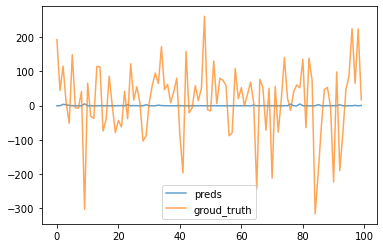

In [456]:
# atten2_predictions = atten_2.predict(X_test[:,np.newaxis,:], verbose= 1)
plt.plot(atten2_predictions[:100,0], alpha = 0.7, label = 'preds')
plt.plot(X_test[:100,0], alpha = 0.7, label = 'groud_truth')
# plt.ylim(0,7)
plt.legend()